In [1]:
# !pip install torch==2.2.2 torchtext==0.17.2 nltk
# !pip install torchdata==0.7.1
# !pip install pyarrow

In [1]:
import torch
import os
import pickle
from model import ClassificationNet, train_epoch, evaluate_epoch, save_list_to_file, load_list_from_file
from torch.optim.lr_scheduler import CosineAnnealingLR

In [2]:
from dataloader import get_dataloaders, DEVICE

print("Imported successfully!")
print(f"Running on device: {DEVICE}")

BATCH_SIZE = 64
train_dataloader, valid_dataloader, test_dataloader, vocab = get_dataloaders(batch_size=BATCH_SIZE)

# --- Verification Step ---
print("\nVerifying by fetching one batch from train_dataloader...")
labels, texts = next(iter(train_dataloader))

print(f"Labels batch shape: {labels.shape}")
print(f"Texts batch shape: {texts.shape}")

Imported successfully!
Running on device: cuda
Loading data from Parquet files...
Vocabulary Size: 95811

Verifying by fetching one batch from train_dataloader...
Labels batch shape: torch.Size([64])
Texts batch shape: torch.Size([64, 65])


In [3]:
vocab_size = len(vocab)
num_classes = 4

In [4]:
EXPERIMENT_DIR = "runs/adam_from_epoch101"
METRICS_DIR = os.path.join(EXPERIMENT_DIR, "metrics") 
os.makedirs(EXPERIMENT_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True) 

print(f"Experiment artifacts will be saved in: {EXPERIMENT_DIR}")
print(f"Metrics will be saved in: {METRICS_DIR}")

Experiment artifacts will be saved in: runs/adam_from_epoch101
Metrics will be saved in: runs/adam_from_epoch101/metrics


In [5]:
model = ClassificationNet(vocab_size=vocab_size, num_class=num_classes).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

In [6]:
# define tits parameters after loading the checkpoint
scheduler = None

In [7]:
start_epoch = 1
best_val_accuracy = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

In [8]:
BASE_CHECKPOINT_PATH = 'runs/adam_from_epoch71/checkpoint.pth'

In [10]:
if os.path.exists(BASE_CHECKPOINT_PATH):
    print(f"Found base checkpoint. Initializing model with weights from '{BASE_CHECKPOINT_PATH}'...")
    checkpoint = torch.load(BASE_CHECKPOINT_PATH)
    
    model.load_state_dict(checkpoint['model_state_dict']) # Load weights only
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    print("Resetting learning rate to 0.00075 for the new schedule...")
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.00075
        
    start_epoch = checkpoint['epoch'] + 1
    history = checkpoint['history']                       # Continue history
    best_val_accuracy = checkpoint['best_val_accuracy']
    
else:
    print("No checkpoints found. Starting a completely new training run.")

Found base checkpoint. Initializing model with weights from 'runs/adam_from_epoch71/checkpoint.pth'...
Resetting learning rate to 0.00075 for the new schedule...


In [11]:
start_epoch

101

In [12]:
EPOCHS = 120

remaining_epochs = EPOCHS - start_epoch + 1
scheduler = CosineAnnealingLR(optimizer, T_max=remaining_epochs, eta_min=1e-7)

In [13]:
remaining_epochs

20

In [14]:
optimizer.param_groups[0]['lr']

0.00075

In [15]:
print(f"Starting training from epoch {start_epoch}...")

for epoch in range(start_epoch, EPOCHS + 1):
    print("-" * 50)
    print(f"Epoch {epoch}/{EPOCHS}")
    
    # Run training and validation
    train_loss, train_acc = train_epoch(model, train_dataloader, criterion, optimizer, DEVICE)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    
    val_loss, val_acc = evaluate_epoch(model, valid_dataloader, criterion, DEVICE)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    scheduler.step()
    
    # Get current LR to print it
    current_lr = optimizer.param_groups[0]['lr']
    
    # summary
    print(f"\nEpoch Summary:")
    print(f"\tTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\tValid Loss: {val_loss:.4f} | Valid Acc: {val_acc*100:.2f}%")
    print(f"\tLearning Rate: {current_lr:.6f}")

    # Save best model to the experiment folder
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model_path = os.path.join(EXPERIMENT_DIR, 'best_model.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved to '{best_model_path}'")

print("-" * 50)
print("Training Finished!")
        
        
# Save final history to the experiment folder
for key, value in history.items():
    file_path = os.path.join(METRICS_DIR, f"{key}.pkl")
    save_list_to_file(value, file_path)

Training:   0%|          | 0/1725 [00:00<?, ?it/s]

Starting training from epoch 101...
--------------------------------------------------
Epoch 101/120


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 139.14it/s, loss=0.3062]



Epoch Summary:
	Train Loss: 0.3017 | Train Acc: 89.79%
	Valid Loss: 0.3062 | Valid Acc: 90.79%
	Learning Rate: 0.000745


Training:   0%|          | 4/1725 [00:00<00:49, 34.57it/s, loss=0.2568]

New best model saved to 'runs/adam_from_epoch101/best_model.pth'
--------------------------------------------------
Epoch 102/120


Training:   0%|          | 4/1725 [00:00<00:44, 38.83it/s, loss=0.2686]


Epoch Summary:
	Train Loss: 0.3089 | Train Acc: 89.64%
	Valid Loss: 0.3152 | Valid Acc: 90.19%
	Learning Rate: 0.000732
--------------------------------------------------
Epoch 103/120


Training:   0%|          | 2/1725 [00:00<01:30, 19.00it/s, loss=0.3527]


Epoch Summary:
	Train Loss: 0.3098 | Train Acc: 89.50%
	Valid Loss: 0.2976 | Valid Acc: 90.79%
	Learning Rate: 0.000709
--------------------------------------------------
Epoch 104/120


Training:   0%|          | 4/1725 [00:00<00:45, 37.53it/s, loss=0.3753]


Epoch Summary:
	Train Loss: 0.3122 | Train Acc: 89.51%
	Valid Loss: 0.3236 | Valid Acc: 89.86%
	Learning Rate: 0.000678
--------------------------------------------------
Epoch 105/120


Training:   0%|          | 4/1725 [00:00<00:45, 38.21it/s, loss=0.3181]


Epoch Summary:
	Train Loss: 0.3089 | Train Acc: 89.60%
	Valid Loss: 0.3214 | Valid Acc: 90.17%
	Learning Rate: 0.000640
--------------------------------------------------
Epoch 106/120


Training:   0%|          | 3/1725 [00:00<01:01, 27.83it/s, loss=0.3187]


Epoch Summary:
	Train Loss: 0.3011 | Train Acc: 89.91%
	Valid Loss: 0.3192 | Valid Acc: 90.27%
	Learning Rate: 0.000545
--------------------------------------------------
Epoch 108/120


Training:  81%|████████▏ | 1403/1725 [00:34<00:07, 41.29it/s, loss=0.2958]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training:   0%|          | 4/1725 [00:00<00:48, 35.77it/s, loss=0.2521]


Epoch Summary:
	Train Loss: 0.2861 | Train Acc: 90.42%
	Valid Loss: 0.3080 | Valid Acc: 90.77%
	Learning Rate: 0.000375
--------------------------------------------------
Epoch 111/120


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 140.96it/s, loss=0.3004]



Epoch Summary:
	Train Loss: 0.2805 | Train Acc: 90.61%
	Valid Loss: 0.3004 | Valid Acc: 91.15%
	Learning Rate: 0.000316


Training:   0%|          | 3/1725 [00:00<00:58, 29.57it/s, loss=0.2085]

New best model saved to 'runs/adam_from_epoch101/best_model.pth'
--------------------------------------------------
Epoch 112/120


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 126.71it/s, loss=0.2945]



Epoch Summary:
	Train Loss: 0.2757 | Train Acc: 90.81%
	Valid Loss: 0.2945 | Valid Acc: 91.23%
	Learning Rate: 0.000259


Training:   0%|          | 3/1725 [00:00<01:03, 27.27it/s, loss=0.2310]

New best model saved to 'runs/adam_from_epoch101/best_model.pth'
--------------------------------------------------
Epoch 113/120


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 131.93it/s, loss=0.2883]



Epoch Summary:
	Train Loss: 0.2723 | Train Acc: 90.88%
	Valid Loss: 0.2883 | Valid Acc: 91.43%
	Learning Rate: 0.000205


Training:   0%|          | 5/1725 [00:00<00:40, 42.91it/s, loss=0.2461]

New best model saved to 'runs/adam_from_epoch101/best_model.pth'
--------------------------------------------------
Epoch 114/120


Training:   0%|          | 3/1725 [00:00<01:08, 25.31it/s, loss=0.2987]


Epoch Summary:
	Train Loss: 0.2699 | Train Acc: 91.04%
	Valid Loss: 0.2895 | Valid Acc: 91.22%
	Learning Rate: 0.000155
--------------------------------------------------
Epoch 115/120


Training:   0%|          | 4/1725 [00:00<00:45, 38.22it/s, loss=0.2730]


Epoch Summary:
	Train Loss: 0.2679 | Train Acc: 91.02%
	Valid Loss: 0.2916 | Valid Acc: 91.32%
	Learning Rate: 0.000110
--------------------------------------------------
Epoch 116/120


Training:   0%|          | 4/1725 [00:00<00:44, 39.02it/s, loss=0.2518]


Epoch Summary:
	Train Loss: 0.2642 | Train Acc: 91.25%
	Valid Loss: 0.2949 | Valid Acc: 91.17%
	Learning Rate: 0.000072
--------------------------------------------------
Epoch 117/120


Training:   0%|          | 4/1725 [00:00<00:43, 39.31it/s, loss=0.2304]


Epoch Summary:
	Train Loss: 0.2626 | Train Acc: 91.25%
	Valid Loss: 0.2920 | Valid Acc: 91.34%
	Learning Rate: 0.000041
--------------------------------------------------
Epoch 118/120


Training:   0%|          | 3/1725 [00:00<01:05, 26.36it/s, loss=0.2952]


Epoch Summary:
	Train Loss: 0.2627 | Train Acc: 91.11%
	Valid Loss: 0.2921 | Valid Acc: 91.23%
	Learning Rate: 0.000018
--------------------------------------------------
Epoch 119/120


Training:   0%|          | 3/1725 [00:00<01:00, 28.39it/s, loss=0.2743]


Epoch Summary:
	Train Loss: 0.2608 | Train Acc: 91.29%
	Valid Loss: 0.2917 | Valid Acc: 91.26%
	Learning Rate: 0.000005
--------------------------------------------------
Epoch 120/120


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 125.32it/s, loss=0.2914]



Epoch Summary:
	Train Loss: 0.2603 | Train Acc: 91.35%
	Valid Loss: 0.2914 | Valid Acc: 91.28%
	Learning Rate: 0.000000
--------------------------------------------------
Training Finished!


In [16]:
current_checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'history': history,
    'best_val_accuracy': best_val_accuracy
}

torch.save(current_checkpoint, os.path.join(EXPERIMENT_DIR, 'checkpoint.pth'))

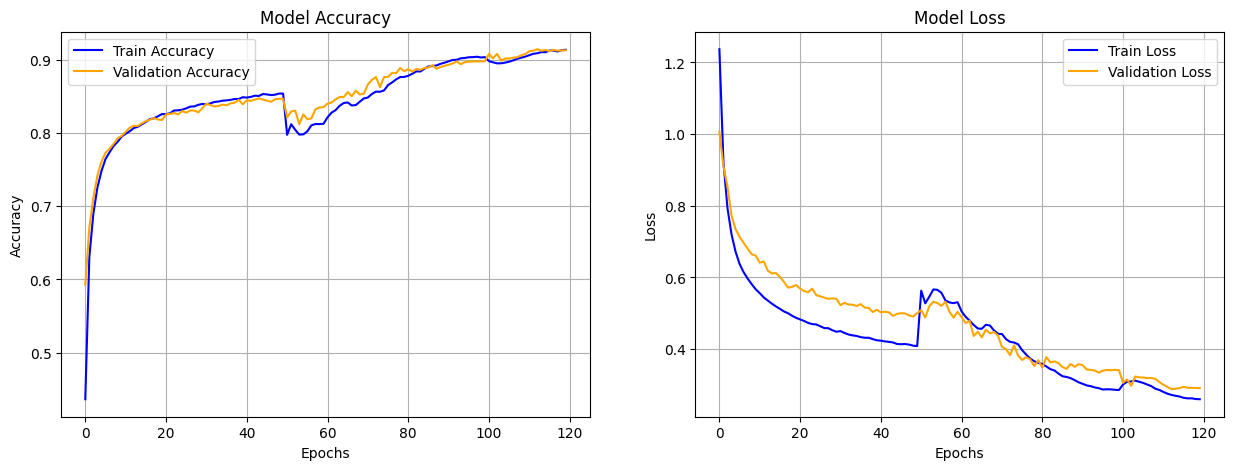

In [17]:
import matplotlib.pyplot as plt

train_losses = history['train_loss']
train_accuracies = history['train_acc']
val_losses = history['val_loss']
val_accuracies = history['val_acc']
    

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plotting Accuracy
ax1.plot(train_accuracies, label='Train Accuracy', color='blue')
ax1.plot(val_accuracies, label='Validation Accuracy', color='orange')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plotting Loss
ax2.plot(train_losses, label='Train Loss', color='blue')
ax2.plot(val_losses, label='Validation Loss', color='orange')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.show()

In [18]:
best_model = ClassificationNet(vocab_size=vocab_size, num_class=num_classes).to(DEVICE)
best_model.load_state_dict(torch.load('runs/adam_from_epoch101/best_model.pth'))
print("Best model loaded and ready for testing.")

Best model loaded and ready for testing.


In [19]:
test_loss, test_acc = evaluate_epoch(best_model, test_dataloader, criterion, DEVICE)

Evaluating: 100%|██████████| 119/119 [00:00<00:00, 170.55it/s, loss=0.3435]


In [20]:
print("-" * 50)
print("Final Test Results:")
print(f"\tTest Loss: {test_loss:.4f}")
print(f"\tTest Accuracy: {test_acc*100:.2f}%")
print("-" * 50)

--------------------------------------------------
Final Test Results:
	Test Loss: 0.3435
	Test Accuracy: 89.99%
--------------------------------------------------
